# Agrupamento de FIIs
O objetivo desse projeto é utilizar uma técnica de aprendizagem de máquina não supervisionada para agrupar os FIIs de acordo com algumas de suas características e indicadores.

## 1. Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set(context='notebook', palette='dark', color_codes=True)

# Factor Analysis
from prince import MCA
from scipy.stats import chi2_contingency
from scipy.stats import norm

# Clustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, fcluster


## 2. Importando Dataset

In [2]:
df = pd.read_csv("data/dados_FIIs_processados.csv")

In [3]:
df.head()

,ticker,nome,tipo_gestao,setor,menos_5_anos,pct_caixa,num_cotistas,PL,PVPA,liquidez_diaria_avg,...,dy_3m_acc,dy_6m_acc,dy_12m_acc,dy_ano,var_preço,rent_periodo,rent_acc,vacancia_fisica,qtd_ativos,valor_mercado
0,SHPH11,Shopping Patio Higienopolis,Passiva,Shoppings,False,0.4134,3105.0,5.013048e+08,0.9803,150895.54,...,0.75,2.23,3.35,1.27,0.00,0.24,-0.33,13.3,1.0,4.914291e+08
1,ALZR11,Alianza Trust Renda Imobiliária,Ativa,Logística,False,1.8679,93070.0,5.450889e+08,1.1276,1676327.17,...,1.59,2.91,4.96,2.91,5.65,6.18,-0.60,0.0,13.0,6.146422e+08
2,BBRC11,BB Renda Corporativa,Passiva,Outros,False,4.0449,8727.0,1.794707e+08,1.0003,201161.93,...,2.30,4.61,8.59,4.61,-3.22,-2.49,-6.74,5.4,20.0,1.795246e+08
3,BTAL11,BTG PACTUAL AGRO LOGÍSTICA,Ativa,Outros,True,33.8504,10544.0,6.132124e+08,0.9588,821338.54,...,1.68,0.00,0.00,2.02,-0.28,0.38,-1.13,0.0,7.0,5.879481e+08
4,BTCR11,BTG Pactual Crédito Imobiliário,Ativa,Títulos e Val. Mob.,False,5.6180,9427.0,4.681521e+08,0.9655,1228057.98,...,2.23,4.24,7.16,4.24,0.83,1.61,10.18,0.0,0.0,4.520008e+08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker               173 non-null    object 
 1   nome                 173 non-null    object 
 2   tipo_gestao          173 non-null    object 
 3   setor                173 non-null    object 
 4   menos_5_anos         173 non-null    bool   
 5   pct_caixa            173 non-null    float64
 6   num_cotistas         173 non-null    float64
 7   PL                   173 non-null    float64
 8   PVPA                 173 non-null    float64
 9   liquidez_diaria_avg  173 non-null    float64
 10  cagr_dividendo       173 non-null    float64
 11  cagr_cota            173 non-null    float64
 12  num_negocios         173 non-null    float64
 13  dy_1m                173 non-null    float64
 14  dy_3m_acc            173 non-null    float64
 15  dy_6m_acc            173 non-null    flo

Pode-se obserar que o dataset possui 3 variáveis categóricas (`tipo_gestao`, `setor` e `menos_5_anos`), sem considerar as variáveis `ticker` e `nome` que servem apenas para identificar o Fundo. As demais 19 variáveis são quantitativas.

As técnicas de agrupamento funcionam tendo como base o conceito de distância que só pode ser calculado entre variáveis quantitativas. Torna-se necessário, dessa forma, a transformação das variáveis categóricas em variáveis numéricas, sem incorrer em ponderação arbitrária. 

## 3. Análise de Correspondência Múltipla

Como possuimos 3 variáveis categóricas, será necessário realizar uma análise de Correspondência Múltipla. 

Primeiramente será necessário realizar testes de chi-quadrado com cada par de variáveis a fim de constatar algum relacionamento entre elas.

### 3.1. Teste de Chi Quadrado
#### 3.1.1. Setor x Tipo de Gestão

In [5]:
cont_tab = pd.crosstab(df['setor'], df['tipo_gestao'])
cont_tab

tipo_gestao,Ativa,Passiva
setor,,
Hospital,0,2
Hotel,1,0
Híbrido,24,2
Lajes Corporativas,10,12
Logística,15,2
Outros,21,4
Residencial,2,0
Shoppings,8,7
Títulos e Val. Mob.,59,4


In [6]:
def eval_chi2(cont_tab):
    chi2, p, dof, _ = chi2_contingency(cont_tab, correction=False)
    print(f"Chi-quadrado: {chi2:.2f}")
    print(f"P-value: {p}")
    print(f"Graus de Liberdade: {dof}")
    print("-------")
    if p < 0.05:
        print('É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.')
    else:
        print("NÃO É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.")


In [7]:
eval_chi2(cont_tab)

Chi-quadrado: 44.05
P-value: 5.557130715586873e-07
Graus de Liberdade: 8
-------
É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.


#### 3.1.2. Setor x Menos de 5 Anos

In [8]:
cont_tab = pd.crosstab(df['setor'], df['menos_5_anos'])
cont_tab

menos_5_anos,False,True
setor,,
Hospital,2,0
Hotel,1,0
Híbrido,11,15
Lajes Corporativas,13,9
Logística,9,8
Outros,10,15
Residencial,0,2
Shoppings,10,5
Títulos e Val. Mob.,25,38


In [9]:
eval_chi2(cont_tab)

Chi-quadrado: 11.10
P-value: 0.1963118462474281
Graus de Liberdade: 8
-------
NÃO É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.


#### 3.1.3. Tipo de Gestão x Menos de 5 Anos

In [10]:
cont_tab = pd.crosstab(df['tipo_gestao'], df['menos_5_anos'])
cont_tab

menos_5_anos,False,True
tipo_gestao,,
Ativa,53,87
Passiva,28,5


In [11]:
eval_chi2(cont_tab)

Chi-quadrado: 23.68
P-value: 1.1353569627207682e-06
Graus de Liberdade: 1
-------
É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.


### 3.2. Análise de Correspondência

Como houve significância estatística na associação em, pelo menos, um dos casos, a análise de correspondência pode ser realizada.

Como o objetivo dessa análise de correspondência múltipla é transformar as variáveis categoricas em variáveis numéricas, todos os **10 componentes** (13 categorias - 3 variáveis) serão utilizados.

In [12]:
df_cat = df.iloc[:,2:5].astype(str)

componentes = df[['menos_5_anos', 'tipo_gestao', 'setor']].nunique().sum() - 3

mca = MCA(n_components = componentes, n_iter = 3, random_state = 42)
mca.fit(df_cat)

df_mca = mca.transform(df_cat)
df_mca.columns = map(lambda x: "V" + str(x), df_mca.columns)

df_mca.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,1.577637,0.183631,-0.144294,0.951893,0.412388,-0.873057,-0.605294,0.664251,0.202058,0.271189
1,0.081298,0.952733,-0.295913,0.732139,-1.105389,0.231115,0.091768,-0.767056,-0.239492,-0.220551
2,0.977318,-0.307159,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,-0.638125,0.703834
3,-0.542586,-0.457999,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,0.163955,-0.018615
4,-0.091541,0.311390,-0.472190,-0.339444,0.246898,-0.182798,-0.055808,-0.075683,-0.671755,-0.202932


In [13]:
mca_summary = pd.DataFrame({'Autovalor' : mca.eigenvalues_, 
                            '% da Var.' : mca.explained_inertia_, 
                            '% da Var. Acumulada' : np.cumsum(mca.explained_inertia_)})
mca_summary

,Autovalor,% da Var.,% da Var. Acumulada
0,0.579330,0.173799,0.173799
1,0.353884,0.106165,0.279964
2,0.333333,0.100000,0.379964
3,0.333333,0.100000,0.479964
4,0.333333,0.100000,0.579964
5,0.333333,0.100000,0.679964
6,0.333333,0.100000,0.779964
7,0.333333,0.100000,0.879964
8,0.249068,0.074720,0.954685
9,0.151051,0.045315,1.000000


Conforme a tabela acima é possível observar que os 10 componentes conseguem representar 100% da inércia total dos dados.

Com esse procedimento as 3 variáveis categóricas foram transformadas em 10 variáveis quantitativas que se juntarão as outras para que os agrupamentos possam ser montados.

## 4. Juntando os Dados

Primeiro vamos adicionar os tickers dos FIIs como índices do `df_mca`.

In [14]:
df_mca['ticker'] = df['ticker']

df_mca.set_index('ticker', inplace = True)

df_mca.head()


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
ticker,,,,,,,,,,
SHPH11,1.577637,0.183631,-0.144294,0.951893,0.412388,-0.873057,-0.605294,0.664251,0.202058,0.271189
ALZR11,0.081298,0.952733,-0.295913,0.732139,-1.105389,0.231115,0.091768,-0.767056,-0.239492,-0.220551
BBRC11,0.977318,-0.307159,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,-0.638125,0.703834
BTAL11,-0.542586,-0.457999,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,0.163955,-0.018615
BTCR11,-0.091541,0.311390,-0.472190,-0.339444,0.246898,-0.182798,-0.055808,-0.075683,-0.671755,-0.202932


Agora vamos criar um novo DataFrame como base nos dados originais, selecionando somente as variáveis quantitativas.

Por fim precisamos padronizar as variáveis, visto que elas estão em escalas diferentes.

In [15]:
df_clus = df.copy()

df_clus.set_index('ticker', inplace = True)

df_clus.drop(['nome', 'tipo_gestao', 'setor', 'menos_5_anos'], axis = 1, inplace = True)

df_clus = pd.DataFrame(StandardScaler().fit_transform(df_clus), 
                       columns=df_clus.columns, 
                       index = df_clus.index)

df_clus.head()

,pct_caixa,num_cotistas,PL,PVPA,liquidez_diaria_avg,cagr_dividendo,cagr_cota,num_negocios,dy_1m,dy_3m_acc,dy_6m_acc,dy_12m_acc,dy_ano,var_preço,rent_periodo,rent_acc,vacancia_fisica,qtd_ativos,valor_mercado
ticker,,,,,,,,,,,,,,,,,,,
SHPH11,-0.581363,-0.540372,-0.216088,0.230465,-0.658517,-1.154686,-0.841473,-0.433001,-0.727959,-1.147317,-0.591135,-0.546564,-1.185064,0.568155,0.406705,0.299703,0.545492,-0.349243,-0.199081
ALZR11,-0.496524,0.939091,-0.161060,1.083118,0.041957,-0.565301,1.506633,-0.297438,-0.393198,-0.387216,-0.290819,-0.195542,-0.437595,2.001115,1.821095,0.276096,-0.391803,0.966597,-0.044905
BBRC11,-0.369541,-0.447919,-0.620569,0.346235,-0.635435,0.123634,-0.962779,-0.424184,-0.045048,0.255250,0.459970,0.595890,0.337220,-0.248505,-0.243343,-0.260752,-0.011247,1.734170,-0.589364
BTAL11,1.368984,-0.418038,-0.075442,0.106011,-0.350651,0.052488,0.084895,-0.320126,-0.165561,-0.305777,-1.575995,-1.276949,-0.843234,0.497141,0.440041,0.229756,-0.391803,0.308677,-0.078307
BTCR11,-0.277784,-0.436407,-0.257754,0.144794,-0.163887,-0.617165,0.084895,-0.355745,-0.018267,0.191908,0.296563,0.284114,0.168584,0.778661,0.732920,1.218641,-0.391803,-0.458896,-0.248417


Unimos ambos os dataframes

In [16]:
df_clus = pd.merge(df_clus, df_mca, left_index=True, right_index=True, how = 'inner')
df_clus.head()

,pct_caixa,num_cotistas,PL,PVPA,liquidez_diaria_avg,cagr_dividendo,cagr_cota,num_negocios,dy_1m,dy_3m_acc,...,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
ticker,,,,,,,,,,,,,,,,,,,,,
SHPH11,-0.581363,-0.540372,-0.216088,0.230465,-0.658517,-1.154686,-0.841473,-0.433001,-0.727959,-1.147317,...,1.577637,0.183631,-0.144294,0.951893,0.412388,-0.873057,-0.605294,0.664251,0.202058,0.271189
ALZR11,-0.496524,0.939091,-0.161060,1.083118,0.041957,-0.565301,1.506633,-0.297438,-0.393198,-0.387216,...,0.081298,0.952733,-0.295913,0.732139,-1.105389,0.231115,0.091768,-0.767056,-0.239492,-0.220551
BBRC11,-0.369541,-0.447919,-0.620569,0.346235,-0.635435,0.123634,-0.962779,-0.424184,-0.045048,0.255250,...,0.977318,-0.307159,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,-0.638125,0.703834
BTAL11,1.368984,-0.418038,-0.075442,0.106011,-0.350651,0.052488,0.084895,-0.320126,-0.165561,-0.305777,...,-0.542586,-0.457999,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,0.163955,-0.018615
BTCR11,-0.277784,-0.436407,-0.257754,0.144794,-0.163887,-0.617165,0.084895,-0.355745,-0.018267,0.191908,...,-0.091541,0.311390,-0.472190,-0.339444,0.246898,-0.182798,-0.055808,-0.075683,-0.671755,-0.202932


## 5. Agrupamentos (Clustering)

Vamos utilizar diferentes técnicas de agrupamentos para analisar os diferentes tipos de resultados e escolher o que mais se adequa ao nosso caso.

### 5.1. Métodos Hierárquicos

#### 5.1.1. Vizinho Mais Próximo e Distância Euclidiana

In [17]:
cluster_single = linkage(df_clus, method = 'single', metric = 'euclidean')

In [18]:
def plot_dendrogram(cluster, limit_distance = 2, readable = True):
    if readable:
        fig_size = (25, 40)
        leaf_rot = 0
        orientation = 'right'
        font = 10
        plot_line = plt.vlines
    else:
        fig_size = (18, 10)
        leaf_rot = 90
        orientation = 'top'
        font = 6
        plot_line = plt.hlines
    
    
    fig = plt.figure(figsize=fig_size)
    dn = dendrogram(cluster, 
                    labels = df_clus.index, 
                    leaf_rotation = leaf_rot, 
                    color_threshold= limit_distance, 
                    orientation = orientation, 
                    leaf_font_size = font)
    plot_line(limit_distance, 0, 10000, linestyle='dashed', color='black')

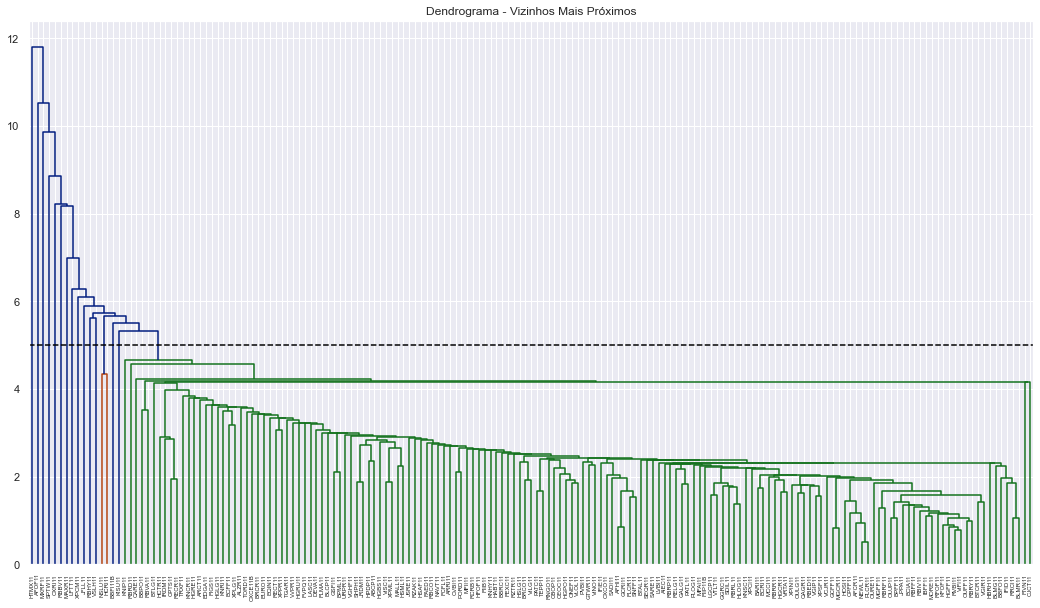

In [19]:
limit_distance = 5
plot_dendrogram(cluster_single, limit_distance, readable=False)
plt.title("Dendrograma - Vizinhos Mais Próximos")
plt.show()

Gerou muitos grupos de um único FII e um grande grupo com vários FIIs.

#### 5.1.2. Vizinho Mais Longe e Distância Euclidiana

In [20]:
cluster_complete = linkage(df_clus, method = 'complete', metric = 'euclidean')

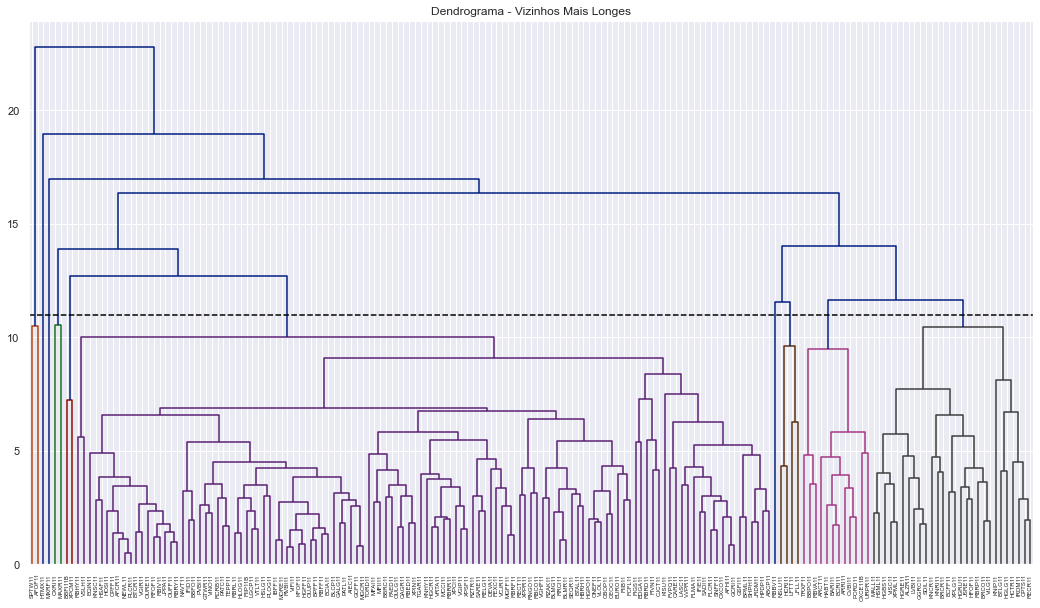

In [21]:
limit_distance = 11
plot_dendrogram(cluster_complete, limit_distance, readable=False)
plt.title("Dendrograma - Vizinhos Mais Longes")
plt.show()

Já foi possível alcançar uma melhor distribuição de grupos, porém ainda possui um grupo muito grande e foi necessário agrupar fundos com grandes distâncias.

#### 5.1.3. Vizinho Médio e Distância Euclidiana

In [22]:
cluster_average = linkage(df_clus, method = 'average', metric = 'euclidean')

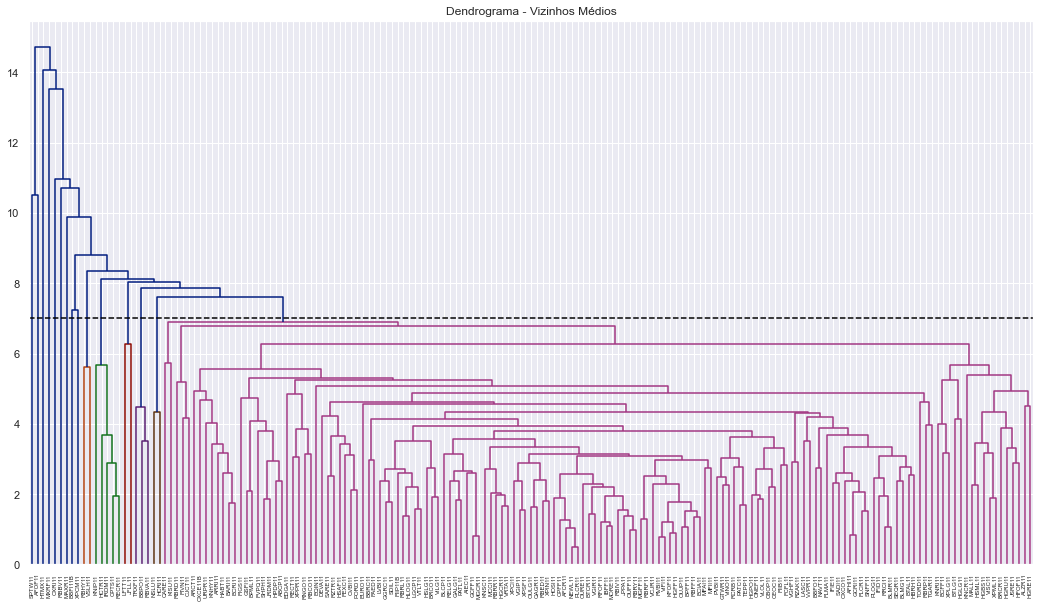

In [23]:
limit_distance = 7
plot_dendrogram(cluster_average, limit_distance, readable=False)
plt.title("Dendrograma - Vizinhos Médios")
plt.show()

Novamente, os fundos acabam se concentrando em um grande grupo.

#### 5.1.4. Centróide e Distância Euclidiana

In [24]:
cluster_centroid = linkage(df_clus, method = 'centroid', metric = 'euclidean')

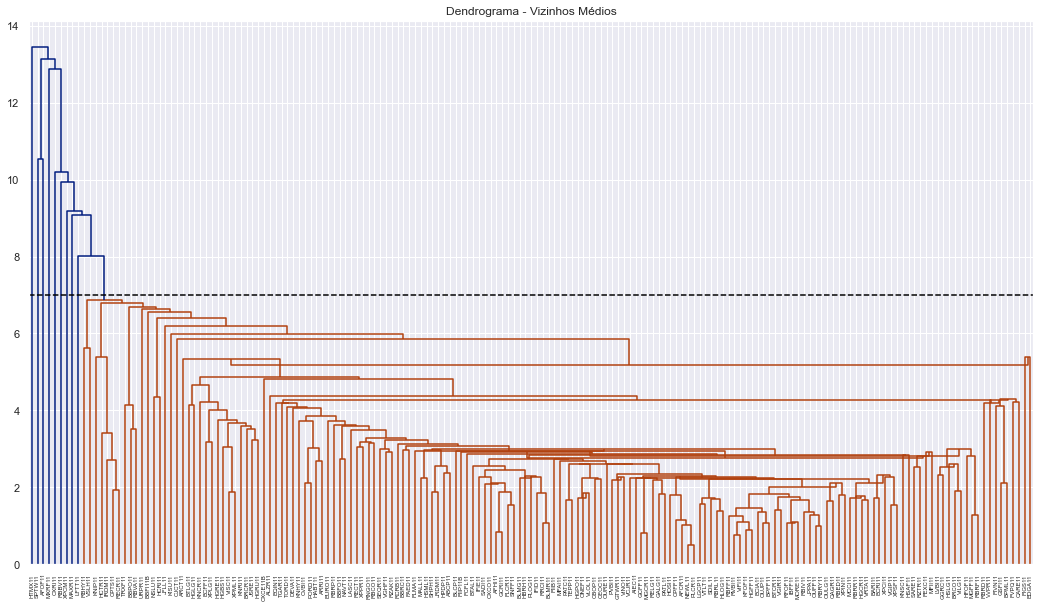

In [25]:
limit_distance = 7
plot_dendrogram(cluster_centroid, limit_distance, readable=False)
plt.title("Dendrograma - Vizinhos Médios")
plt.show()

#### 5.1.5. Ward e Distância Euclidiana

In [26]:
cluster_ward = linkage(df_clus, method = 'ward', metric = 'euclidean')

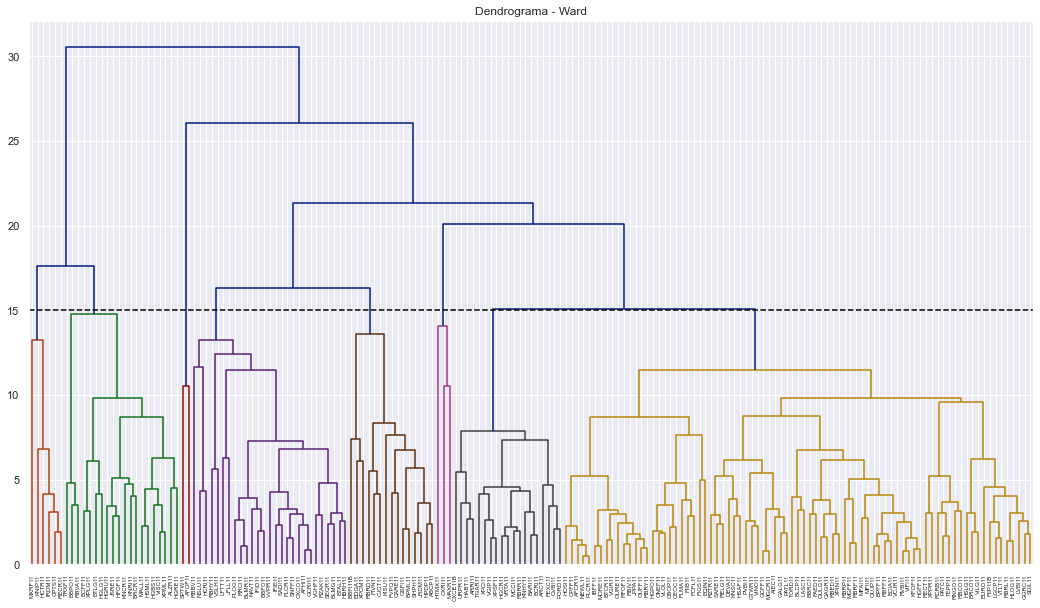

In [27]:
limit_distance = 15
plot_dendrogram(cluster_ward, limit_distance, readable=False)
plt.title("Dendrograma - Ward")
plt.show()

Com o algorítimo de Ward (minimiza a variância), conseguiu agrupar os Fundos em mais grupos.

#### 5.1.6. Vizinho Mais Longe com Similaridade de Correlação

In [28]:
cluster_test = linkage(df_clus, method = 'complete', metric = 'correlation')

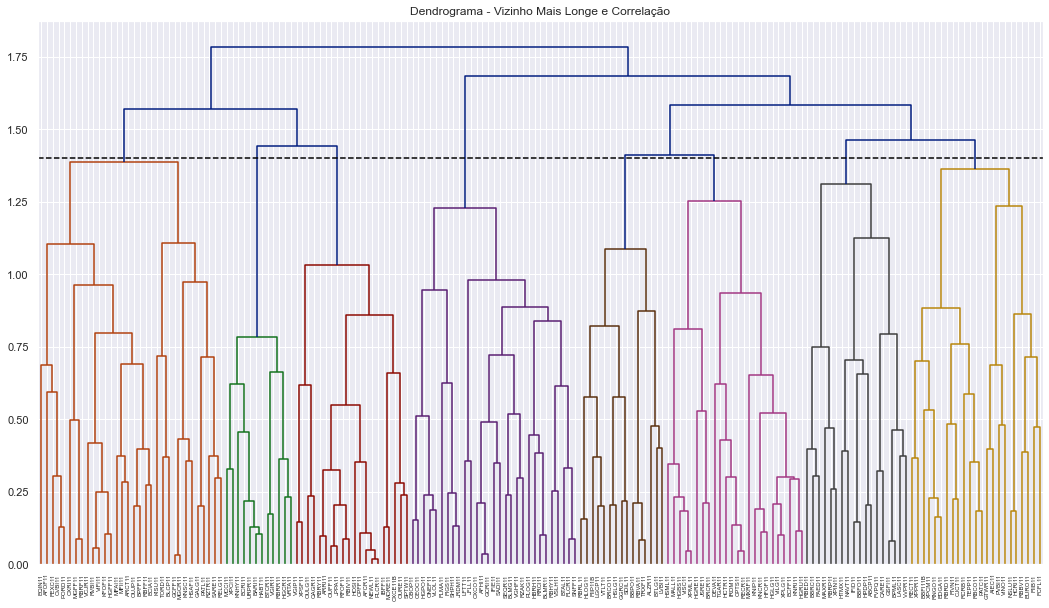

In [29]:
limit_distance = 1.4
plot_dendrogram(cluster_test, limit_distance, readable=False)
plt.title("Dendrograma - Vizinho Mais Longe e Correlação")
plt.show()

Há uma boa separação de grupos, mais ou menos homogênios em quantidade de ativos.